In [1]:
from pathlib import Path

import plotnine as pn
import polars as pl
import statsmodels.formula.api as smf

In [2]:
path = Path("data/me-minipile-regdata")

df = (
    pl.scan_parquet(list(path.glob("*parquet")), include_file_paths="filename")
    .with_columns(filename=pl.col("filename").str.split("/").list.get(-1).str.strip_suffix(".parquet"))
    .with_columns(
        tokenizer=pl.col("filename").str.extract("((bpe2wp)|(bpe)|(wordpiece))"),
        vocab_size=pl.col("filename").str.extract_all("(\d+)").list.get(-1).cast(pl.Int32),
        model_size=pl.col("filename").str.split("_").list.get(0).str.strip_prefix("me"),
    )
    .drop("filename")
    .collect()
    .shrink_to_fit()
)

In [3]:
# check
(
    df.group_by(["step", "vocab_size", "model_size", "tokenizer"])
    .len()
    .group_by(["vocab_size", "model_size", "tokenizer"])
    .agg(pl.col("len").unique())
    .pivot(on="model_size", values="len")
    .sort(["vocab_size", "tokenizer"])
    .sort(["tokenizer", "vocab_size"])
)

vocab_size,tokenizer,57M-tied,100M-tied,850M,340M-tied,100M
i32,str,list[u64],list[u64],list[u64],list[u64],list[u64]
8064,"""bpe""",[9709],null,null,null,null
32000,"""bpe""",[9859],[9859],[9859],[9859],[9859]
128000,"""bpe""",[7463],null,null,null,null
32000,"""bpe2wp""",[7503],null,null,null,null
32000,"""wordpiece""",[7734],null,null,null,null


In [4]:
effects = []
for model_size in df["model_size"].unique().sort():
    for vocab_size in df["vocab_size"].unique().sort():
        for tokenizer in df["tokenizer"].unique().sort():
            for step in df["step"].unique().sort():
                for target in ["mean", "median", "std", "iqr"]:
                    reg_df = (
                        df.filter(
                            (pl.col("model_size") == model_size)
                            & (pl.col("vocab_size") == vocab_size)
                            & (pl.col("tokenizer") == tokenizer)
                            & (pl.col("step") == step)
                        )
                        .drop_nans(subset=[target])
                        .with_columns(pl.col("tok") / 1000)
                        .to_pandas()
                    )

                    if reg_df.empty:
                        continue

                    # covariates = "bs(tok, df=1, degree=1, include_intercept=False)"
                    covariates = "tok"
                    model = smf.ols(f"{target} ~ {covariates} + treat", data=reg_df)
                    res = model.fit().get_robustcov_results(cov_type="HC1")

                    fittedvalues = {}
                    for t in [True, False]:
                        reg_df_predict = reg_df.copy()
                        reg_df_predict["treat"] = t
                        fittedvalues[t] = res.predict(reg_df_predict)

                    # Get the coefficient and confidence intervals
                    treat_idx = res.model.exog_names.index("treat[T.True]")
                    ate, (lower, upper) = res.params[treat_idx], res.conf_int()[treat_idx]
                    r2 = res.rsquared
                    pvalue = res.pvalues[treat_idx]

                    effects.append(
                        {
                            "vocab_size": vocab_size,
                            "model_size": model_size,
                            "tokenizer": tokenizer,
                            "step": step,
                            "target": target,
                            "ate": ate,
                            "lower": lower,
                            "upper": upper,
                            "r2": r2,
                            "pvalue": pvalue,
                            "tok": reg_df["tok"].tolist(),
                            "fitted": res.fittedvalues.tolist(),
                            "fitted_off": fittedvalues[False].tolist(),
                            "fitted_on": fittedvalues[True].tolist(),
                            "data": reg_df[target].tolist(),
                            "treat": reg_df["treat"].tolist(),
                        }
                    )

edf = pl.DataFrame(effects)

In [22]:
# NOTE: in the export of runs 100M, 100 the step 0 got overwritten with the step 50k
edf = edf.with_columns(
    ate=pl.when((pl.col("step") == 0) & (pl.col("ate") < 3))
    .then(12)  # Set to step 0
    .otherwise(pl.col("ate"))
)

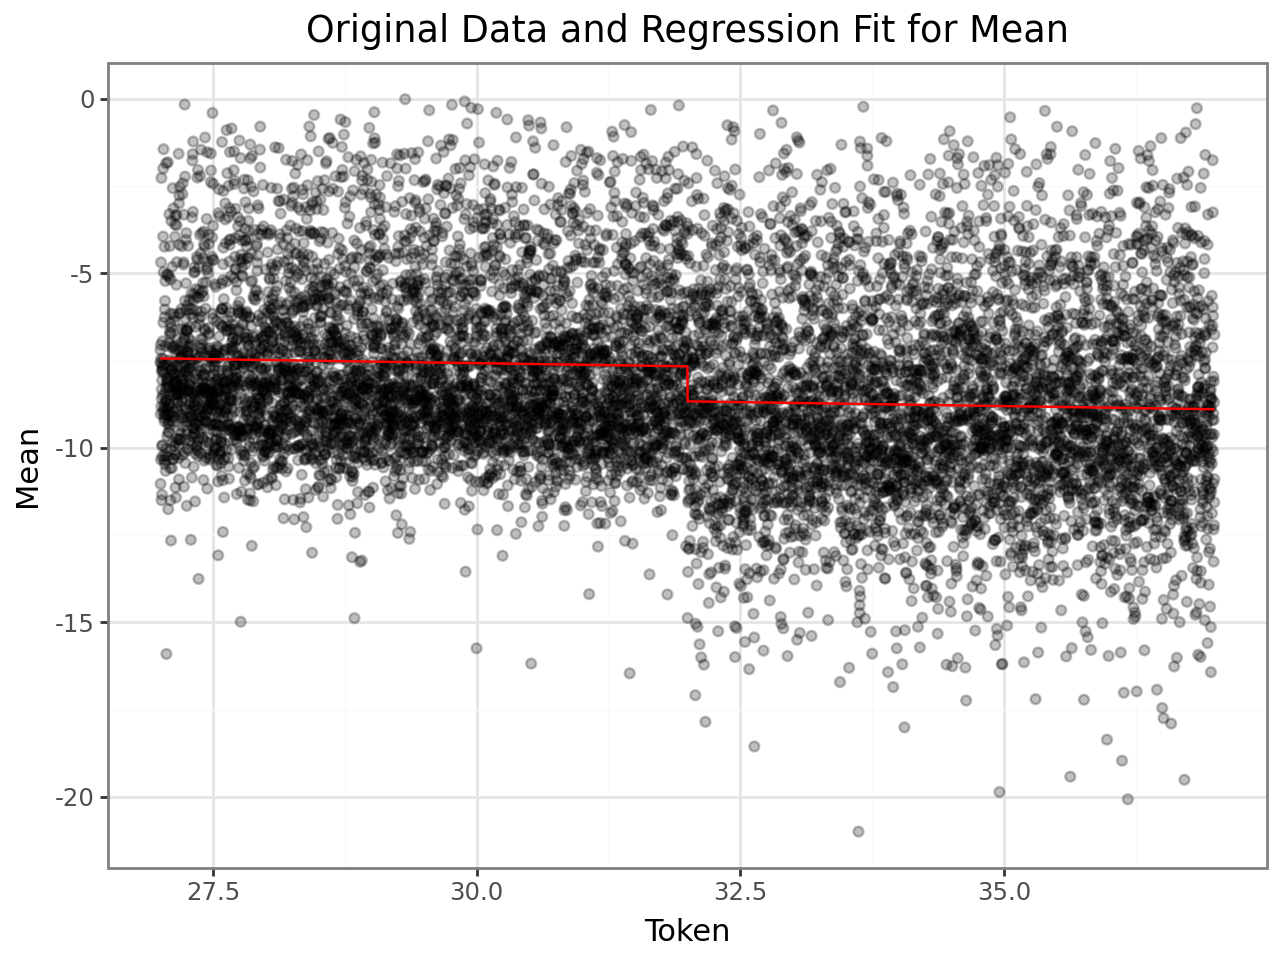

In [140]:
# Prepare data for plotting
target = "mean"
pdata = (
    edf.filter(
        (pl.col("target") == target)
        & (pl.col("tokenizer") == "bpe")
        & (pl.col("step") == 2000)
        & (pl.col("model_size") == "850M")
        & (pl.col("vocab_size") == 32000)
    )
    .select(["tok", "fitted", "data"])
    .explode(["tok", "fitted", "data"])
)

# Plot original data and regression fit using plotnine
p = (
    pn.ggplot(pdata, pn.aes(x="tok", y="data"))
    + pn.geom_point(alpha=0.25)
    + pn.geom_line(pn.aes(y="fitted"), color="red")
    + pn.labs(x="Token", y=target.capitalize(), title=f"Original Data and Regression Fit for {target.capitalize()}")
    + pn.theme_bw()
)
p.show()

### Plots

In [141]:
import matplotlib.font_manager as fm

# Get the list of available fonts
font_list = fm.findSystemFonts(fontpaths=None, fontext="ttf")

# Filter the list to include only sans serif fonts
sans_serif_fonts = sorted(
    set(
        [
            fm.FontProperties(fname=font).get_name()
            for font in font_list
            if "Sans" in fm.FontProperties(fname=font).get_name()
        ]
    )
)

# Print the list of sans serif fonts
for font in sans_serif_fonts:
    print(font)

DejaVu Sans
DejaVu Sans Mono
Droid Sans Fallback
Latin Modern Sans
Latin Modern Sans Demi Cond
Latin Modern Sans Quotation
Liberation Sans
Liberation Sans Narrow
MathJax_SansSerif
Nimbus Sans
Nimbus Sans Narrow
Noto Sans Mono


In [142]:
plot_path = Path("new_plots")
plot_path.mkdir(exist_ok=True, parents=True)
font = "Nimbus Sans"

/home/pl487/merge-effect/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 2.5 in image.
/home/pl487/merge-effect/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: new_plots/57M-tied_bpe__across_vocab_sizes.pdf


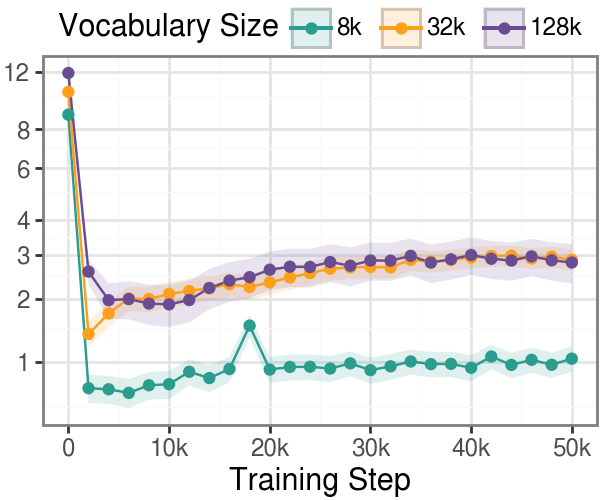

In [143]:
pdata = edf.filter((pl.col("tokenizer") == "bpe") & (pl.col("target") == "mean") & (pl.col("model_size") == "57M-tied"))

cmap = {8064: "#2a9d8f", 32000: "#ff9f1c", 128000: "#6a4c93"}  # "#e76f51"}

bpe_plot = (
    pn.ggplot(
        pdata, pn.aes("step", "ate", ymin="lower", ymax="upper", group="factor(vocab_size)", fill="factor(vocab_size)")
    )
    + pn.geom_ribbon(alpha=0.15)
    + pn.geom_line(pn.aes(colour="factor(vocab_size)"))
    + pn.geom_point(pn.aes(colour="factor(vocab_size)"))
    # + pn.coord_cartesian(ylim=(-0., 3.5))
    + pn.scale_y_symlog(breaks=list(range(5)) + [6, 8, 12])
    + pn.scale_colour_manual(cmap, labels=lambda x: [f"{v / 1000:.0f}k" for v in x])
    + pn.scale_fill_manual(cmap, labels=lambda x: [f"{v / 1000:.0f}k" for v in x])
    + pn.scale_x_continuous(labels=lambda x: [f"{v / 1000:.0f}k" if v > 0 else "0" for v in x])
    + pn.labs(x="Training Step", y="", colour="Vocabulary Size")
    + pn.theme_bw()
    + pn.theme(
        plot_margin=0.005,
        plot_background=None,
        legend_box_spacing=0.005,
        legend_box_margin=0,
        figure_size=(3, 2.5),
        legend_position="top",
        text=pn.element_text(family=font),
    )
    + pn.guides(fill=pn.guide_legend(title="Vocabulary Size"), colour=pn.guide_legend(title="Vocabulary Size"))
    # + pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1, "size": 2.5}))
)
bpe_plot.save(plot_path / "57M-tied_bpe__across_vocab_sizes.pdf")
bpe_plot.show()

/home/pl487/merge-effect/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 2.5 in image.
/home/pl487/merge-effect/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: new_plots/57M-tied_vocab32000__across_tokenisers.pdf


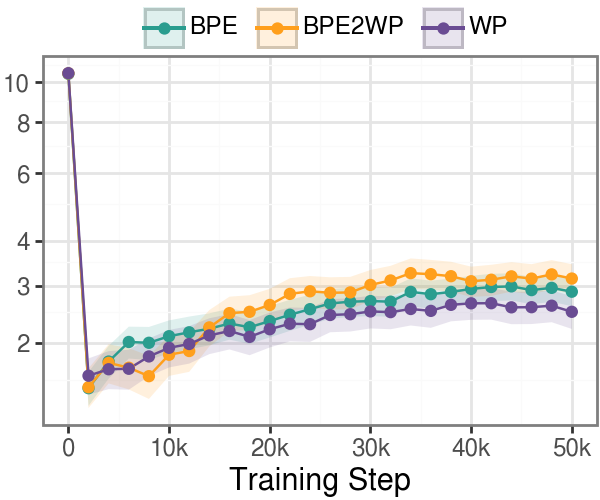

In [144]:
pdata = edf.filter(
    (pl.col("vocab_size") == 32000) & (pl.col("target") == "mean") & (pl.col("model_size") == "57M-tied")
)

cmap = {"bpe": "#2a9d8f", "wordpiece": "#6a4c93", "bpe2wp": "#ff9f1c"}
map = {"bpe": "BPE", "wordpiece": "WP", "bpe2wp": "BPE2WP"}

tok_plot = (
    pn.ggplot(
        pdata, pn.aes("step", "ate", ymin="lower", ymax="upper", group="factor(tokenizer)", fill="factor(tokenizer)")
    )
    + pn.geom_ribbon(alpha=0.15)
    + pn.geom_line(pn.aes(colour="factor(tokenizer)"))
    + pn.geom_point(pn.aes(colour="factor(tokenizer)"))
    # + pn.coord_cartesian(ylim=(-0., 3.5))
    + pn.scale_y_symlog(breaks=list(range(5)) + [6, 8, 10, 12])
    + pn.scale_colour_manual(cmap, labels=lambda x: [map[v] for v in x])
    + pn.scale_fill_manual(cmap, labels=lambda x: [map[v] for v in x])
    + pn.scale_x_continuous(labels=lambda x: [f"{v / 1000:.0f}k" if v > 0 else "0" for v in x])
    + pn.labs(x="Training Step", y="", colour="")
    + pn.theme_bw()
    + pn.theme(
        plot_margin=0.005,
        plot_background=None,
        legend_box_spacing=0.005,
        legend_box_margin=0,
        figure_size=(3, 2.5),
        legend_position="top",
        text=pn.element_text(family=font),
    )
    + pn.guides(fill=pn.guide_legend(title=""), colour=pn.guide_legend(title=""))
    # + pn.guides(colour=pn.guide_legend(override_aes={"alpha": 1, "size": 2.5}))
)
tok_plot.save(plot_path / "57M-tied_vocab32000__across_tokenisers.pdf")
tok_plot.show()

/home/pl487/merge-effect/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 2.5 in image.
/home/pl487/merge-effect/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: new_plots/bpe_vocab32000__across_model_sizes.pdf


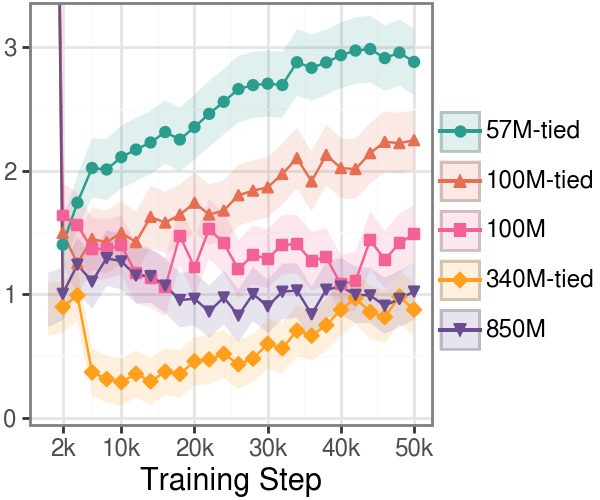

In [145]:
pdata = edf.filter(
    (pl.col("vocab_size") == 32000) & (pl.col("target") == "mean") & (pl.col("tokenizer") == "bpe")
).with_columns(pl.col("model_size").cast(pl.Enum(["57M-tied", "100M-tied", "100M", "340M-tied", "850M"])))

cmap = {"57M-tied": "#2a9d8f", "100M-tied": "#e76f51", "100M": "#f46197", "340M-tied": "#ff9f1c", "850M": "#6a4c93"}

model_plot = (
    pn.ggplot(
        pdata,
        pn.aes("step", "ate", ymin="lower", ymax="upper", group="model_size", fill="model_size", shape="model_size"),
    )
    + pn.geom_ribbon(alpha=0.15)
    + pn.geom_line(pn.aes(colour="model_size"))
    + pn.geom_point(pn.aes(colour="model_size"))
    # + pn.scale_y_symlog(breaks=list(range(5)) + [6, 8, 10, 12])
    + pn.coord_cartesian(ylim=(None, 3.2))  # Keep this - it preserves the line
    + pn.scale_colour_manual(cmap)
    + pn.scale_fill_manual(cmap)
    + pn.scale_x_continuous(
        labels=lambda x: [f"{v / 1000:.0f}k" if v > 0 else "" for v in x],
        breaks=[2000, 10000, 20000, 30000, 40000, 50000],
    )
    + pn.labs(x="Training Step", y="", colour="")
    + pn.theme_bw()
    + pn.theme(
        plot_margin=0.005,
        plot_background=None,
        legend_box_spacing=0.005,
        legend_box_margin=0,
        figure_size=(3, 2.5),
        # legend_position="top",
        text=pn.element_text(family=font),
    )
    + pn.guides(fill=pn.guide_legend(title=""), colour=pn.guide_legend(title=""), shape=pn.guide_legend(title=""))
)
model_plot.save(plot_path / "bpe_vocab32000__across_model_sizes.pdf")
model_plot.show()

In [ ]:
pdata = (
    edf.filter(
        (pl.col("vocab_size") == 32000)
        & (pl.col("tokenizer") == "bpe")
        & (pl.col("model_size") == "57M-tied")
        & (pl.col("step") == pl.col("step").max())
    )
    .with_columns(pl.col("target").cast(pl.Enum(["mean", "median", "std", "iqr"])))
    .select(["tok", "fitted", "fitted_off", "data", "target", "ate", "treat"])
    .explode(["tok", "fitted", "fitted_off", "data", "treat"])
    .with_columns(pl.col("treat").cast(pl.String).cast(pl.Enum(["true", "false"])))
)

cmap = {"true": "#2a9d8f", "false": "#ff9f1c"}
map = {"mean": "Mean", "std": "Standard Deviation", "median": "Median", "iqr": "Interquartile Range"}

ate_data = (
    pdata.group_by(["target"])
    .agg(xpos=pl.col("tok").min(), ypos=pl.col("data").min(), ate=pl.col("ate").unique().round(2))
    .explode(["ate"])
    # .filter(pl.col("treat") == "true")
    .with_columns(ate=pl.format("ATE: {}", pl.col("ate")))
)

metric = (
    pn.ggplot(pdata, pn.aes("tok"))
    + pn.geom_line(pn.aes(y="data"), alpha=0.1)
    + pn.geom_line(pn.aes(y="fitted", colour="treat"), size=1)
    + pn.geom_line(pn.aes(y="fitted_off"), colour=cmap["false"], size=1, linetype="dashed")
    + pn.facet_wrap("target", ncol=4, scales="free_y", labeller=lambda x: map[x])
    + pn.geom_label(
        pn.aes(x="xpos", y="ypos", label="ate"),
        data=ate_data,
        # x=float("-inf"),
        # y=float("-inf"),
        ha="left",
        va="bottom",
        size=10,
        color="black",
    )
    + pn.coord_cartesian()
    + pn.geom_vline(xintercept=32, linetype="dashed")
    + pn.scale_colour_manual(cmap, labels=lambda x: [f"{v.capitalize()}" for v in x])
    + pn.scale_x_continuous(breaks=list(range(28, 38, 2)), labels=lambda x: [f"{v:.0f}k" for v in x])
    + pn.labs(x="Merge Index", y="", colour="Treatment")
    + pn.theme_bw()
    + pn.theme(
        plot_margin=0.005,
        plot_background=None,
        legend_box_spacing=0.005,
        legend_box_margin=0,
        figure_size=(8, 2.5),
        legend_position="top",
        text=pn.element_text(family=font),
    )
)
# metric.save(plot_path / "bpe32000_metrics.pdf")
metric.show()

ShapeError: exploded columns must have matching element counts

In [130]:
pdata = (
    edf.filter(
        (pl.col("vocab_size") == 32000)
        & (pl.col("tokenizer") == "bpe")
        & (pl.col("model_size") == "81M-tied")
        & (pl.col("step") == pl.col("step").max())
    )
    .with_columns(pl.col("target").cast(pl.Enum(["mean", "median", "std", "iqr"])))
    .select(["tok", "fitted", "fitted_off", "data", "target", "ate", "treat"])
    .explode(["tok", "fitted", "fitted_off", "data", "treat"])
    .with_columns(pl.col("treat").cast(pl.String).cast(pl.Enum(["true", "false"])))
)

cmap = {"true": "#2a9d8f", "false": "#ff9f1c"}
map = {"mean": "Mean", "std": "Standard Deviation", "median": "Median", "iqr": "Interquartile Range"}

metric = (
    pn.ggplot(pdata, pn.aes("tok", "data"))
    + pn.geom_line(alpha=0.1)
    + pn.geom_smooth(pn.aes(colour="treat"), method="loess", se=True, span=0.1)
    + pn.facet_wrap("target", ncol=4, scales="free_y", labeller=lambda x: map[x])
    + pn.coord_cartesian()
    + pn.geom_vline(xintercept=32, linetype="dashed")
    + pn.scale_colour_manual(cmap, labels=lambda x: [f"{v.capitalize()}" for v in x])
    + pn.scale_x_continuous(breaks=list(range(28, 38, 2)), labels=lambda x: [f"{v:.0f}k" for v in x])
    + pn.labs(x="Merge Index", y="", colour="Treatment")
    + pn.theme_bw()
    + pn.theme(
        plot_margin=0.005,
        plot_background=None,
        legend_box_spacing=0.005,
        legend_box_margin=0,
        figure_size=(8, 2.5),
        legend_position="top",
        text=pn.element_text(family=font),
    )
)
metric.save(plot_path / "bpe32000_metrics_loess.pdf")
metric.show()

/home/pl487/merge-effect/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 2.5 in image.
/home/pl487/merge-effect/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: new_plots/bpe32000_metrics_loess.pdf


PlotnineError: 'Faceting variables must have at least one value'

/home/pl487/merge-effect/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 7 in image.
/home/pl487/merge-effect/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/alltokenisers32000_metrics.pdf


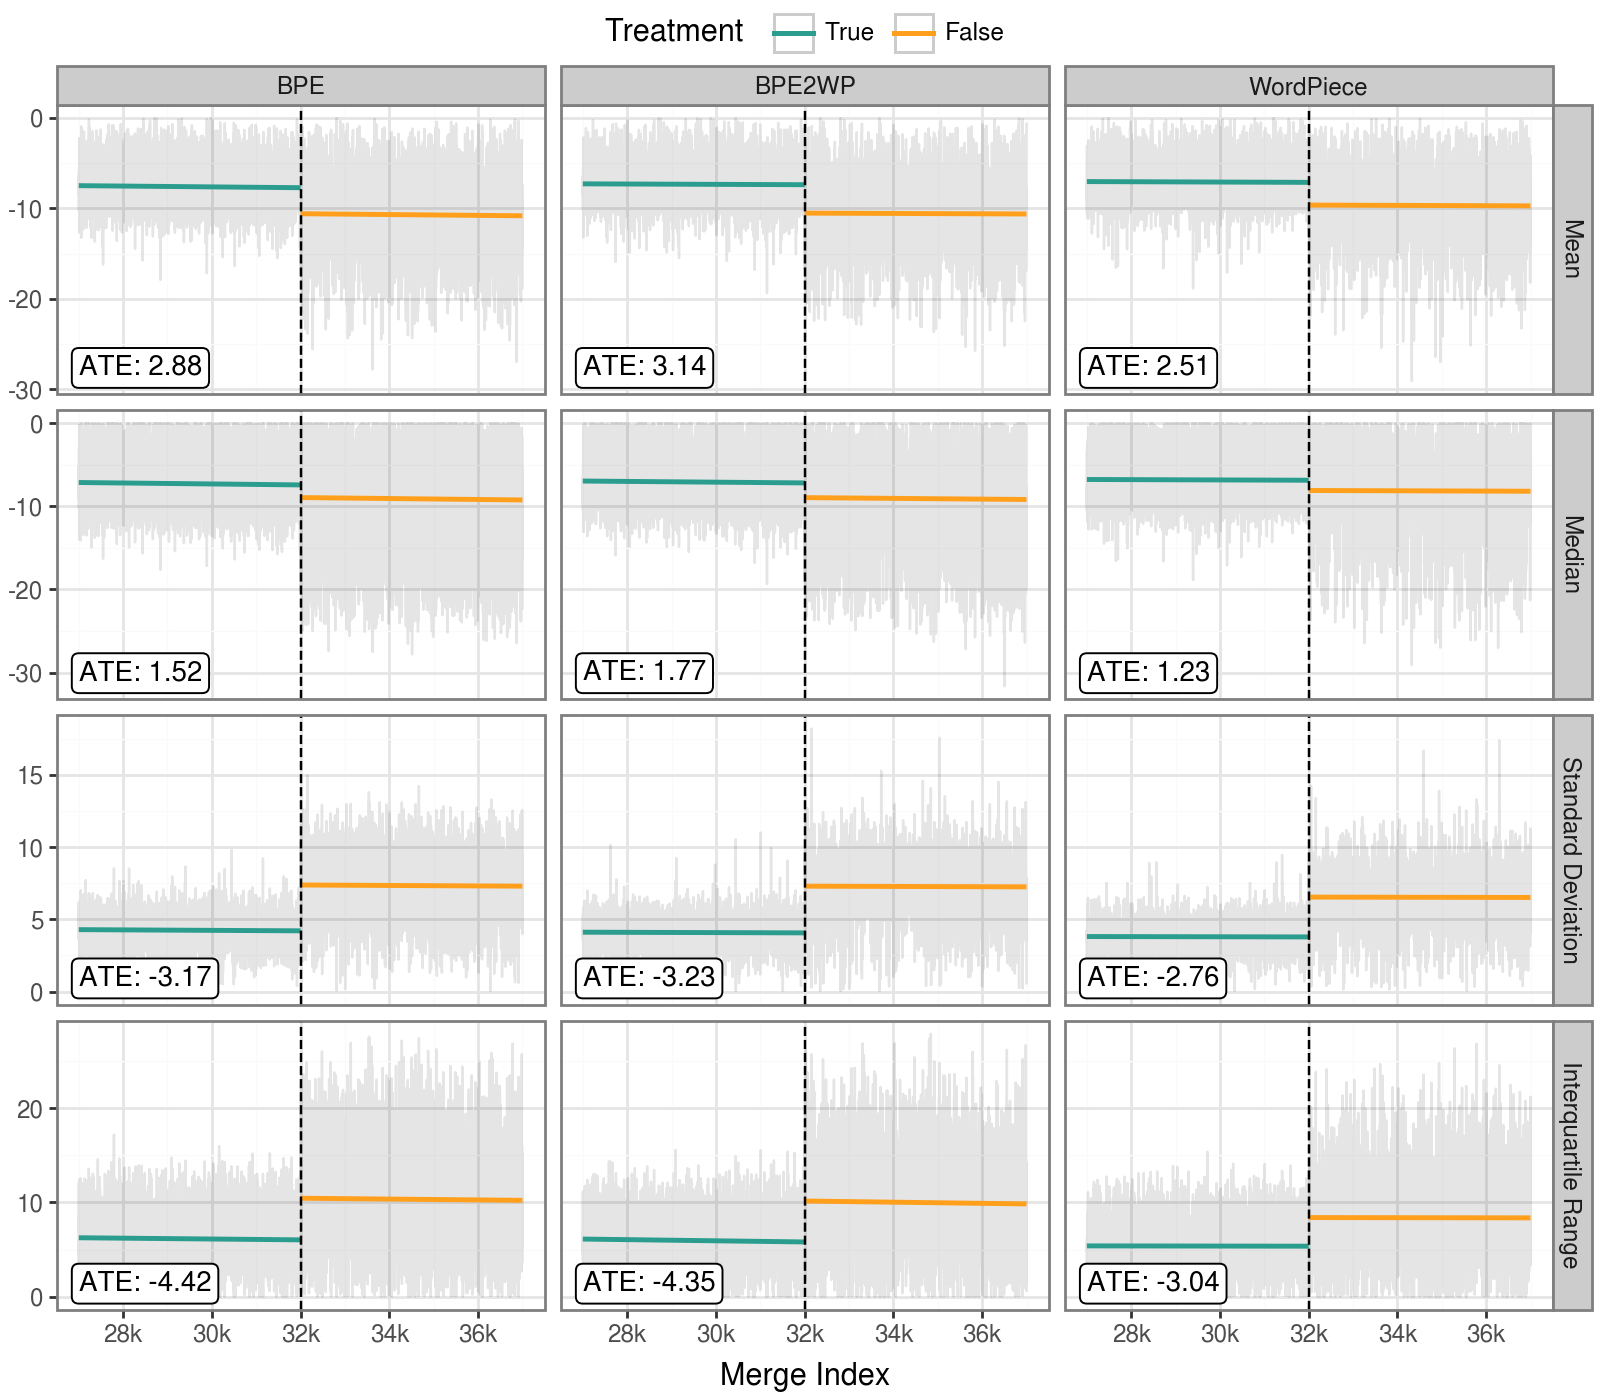

In [43]:
pdata = (
    edf.filter(
        (pl.col("vocab_size") == 32000)
        & (pl.col("model_size") == "81M-tied")
        & (pl.col("step") == pl.col("step").max())
    )
    .with_columns(pl.col("target").cast(pl.Enum(["mean", "median", "std", "iqr"])))
    .select(["tok", "fitted", "data", "target", "ate", "treat", "tokenizer"])
    .explode(["tok", "fitted", "data", "treat"])
    .with_columns(pl.col("treat").cast(pl.String).cast(pl.Enum(["true", "false"])))
)

ate_data = (
    pdata.with_columns(xpos=pl.col("tok").min().over("target"), ypos=pl.col("data").min().over("target"))
    .group_by(["target", "tokenizer"])
    .agg(ate=pl.col("ate").unique().round(2), xpos=pl.col("xpos").first(), ypos=pl.col("ypos").first())
    .explode(["ate"])
    .with_columns(ate=pl.format("ATE: {}", pl.col("ate")))
)

cmap = {"true": "#2a9d8f", "false": "#ff9f1c"}
map = {"mean": "Mean", "std": "Standard Deviation", "median": "Median", "iqr": "Interquartile Range"}
map.update({"bpe": "BPE", "wordpiece": "WordPiece", "bpe2wp": "BPE2WP"})

metric = (
    pn.ggplot(pdata, pn.aes("tok"))
    + pn.geom_line(pn.aes(y="data"), alpha=0.1)
    + pn.geom_line(pn.aes(y="fitted", colour="treat"), size=1)
    + pn.geom_label(
        pn.aes(x="xpos", y="ypos", label="ate"),
        data=ate_data,
        # x=float("-inf"),
        # y=float("-inf"),
        ha="left",
        va="bottom",
        size=10,
        color="black",
    )
    + pn.facet_grid("target ~ tokenizer", scales="free_y", labeller=lambda x: map[x])
    + pn.geom_vline(xintercept=32, linetype="dashed")
    + pn.scale_colour_manual(cmap, labels=lambda x: [f"{v.capitalize()}" for v in x])
    + pn.scale_x_continuous(breaks=list(range(28, 38, 2)), labels=lambda x: [f"{v:.0f}k" for v in x])
    + pn.labs(x="Merge Index", y="", colour="Treatment")
    + pn.theme_bw()
    + pn.theme(
        plot_margin=0.005,
        plot_background=None,
        legend_box_spacing=0.005,
        legend_box_margin=0,
        figure_size=(8, 7),
        legend_position="top",
        text=pn.element_text(family=font),
    )
)
metric.save(plot_path / "alltokenisers32000_metrics.pdf")
metric.show()

/home/pl487/merge-effect/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 7 in image.
/home/pl487/merge-effect/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/bpe_allvocabsizes.pdf


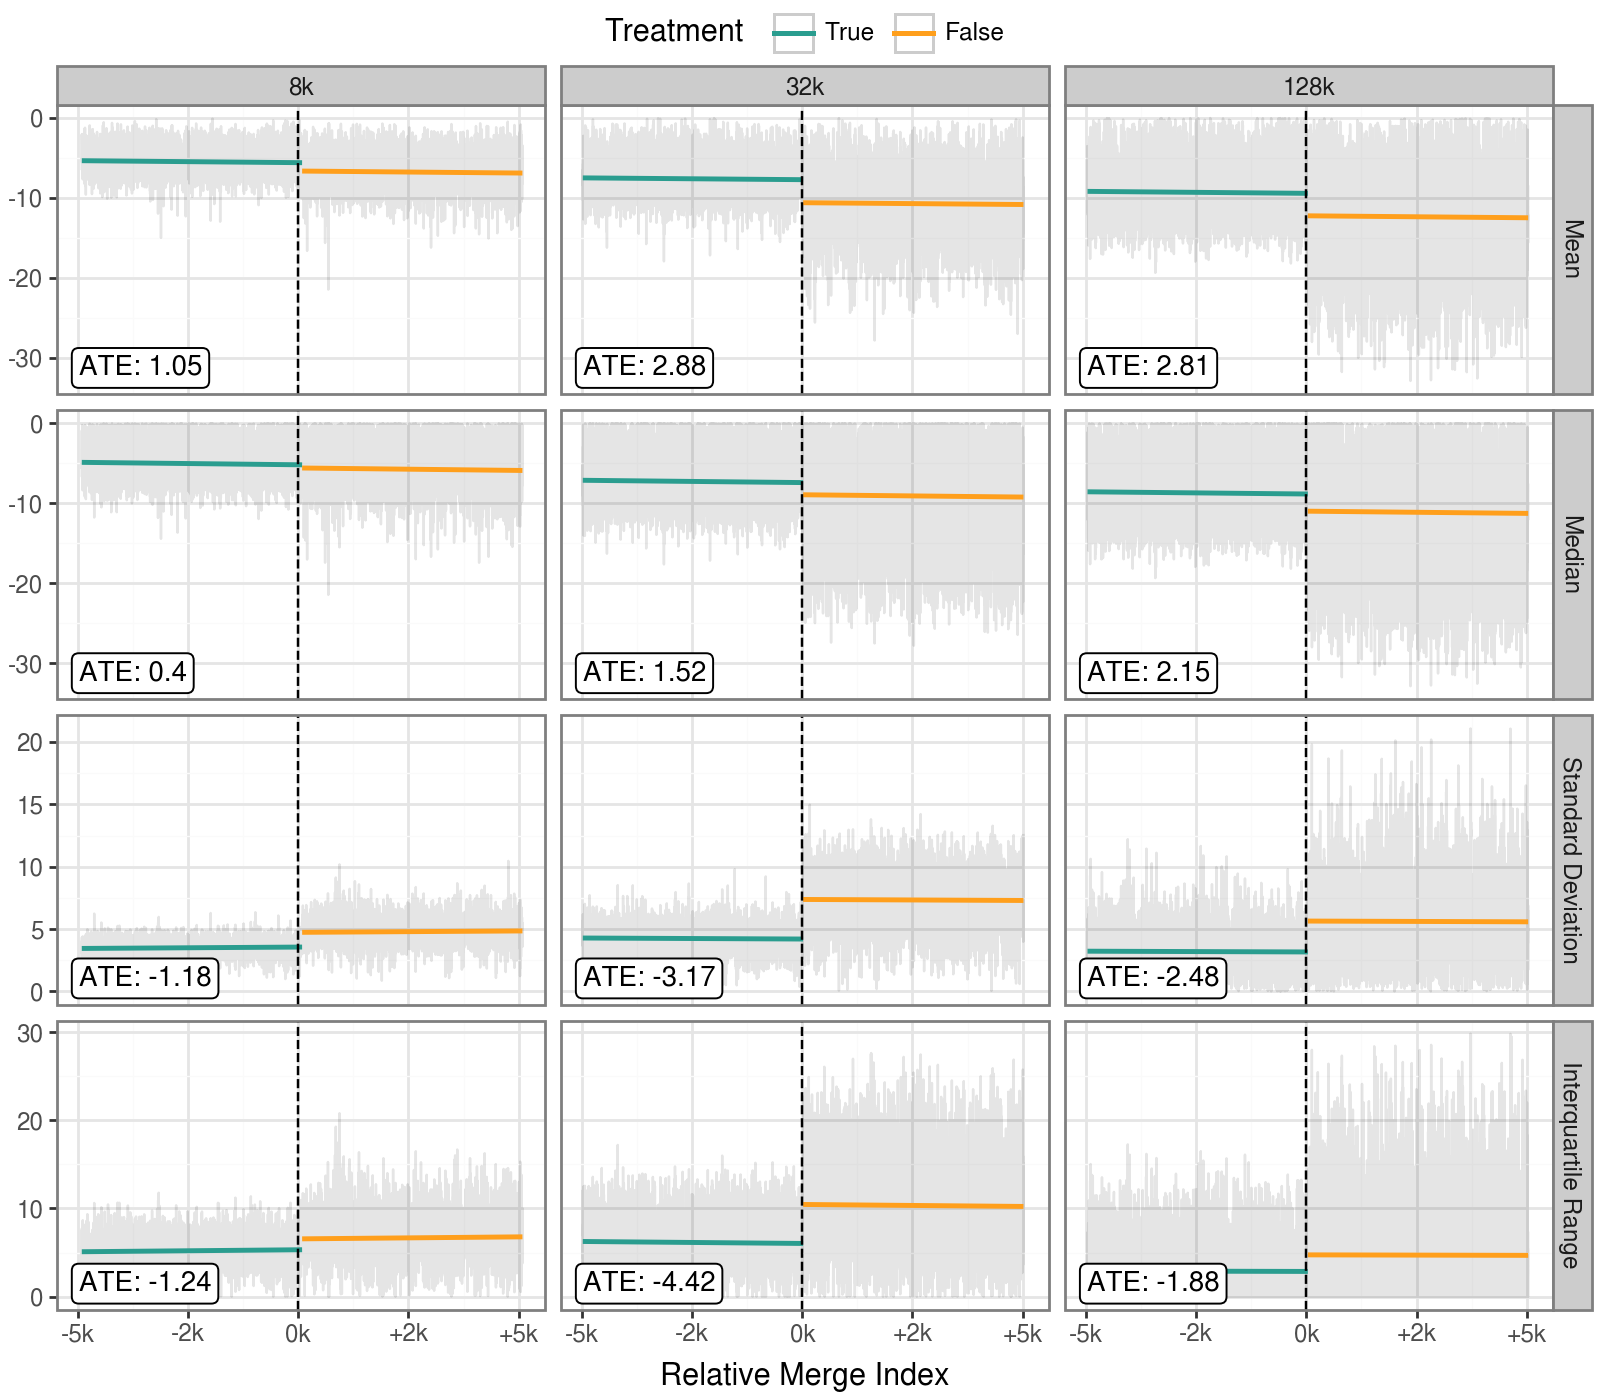

In [44]:
pdata = (
    edf.filter(
        (pl.col("tokenizer") == "bpe") & (pl.col("model_size") == "81M-tied") & (pl.col("step") == pl.col("step").max())
    )
    .with_columns(pl.col("target").cast(pl.Enum(["mean", "median", "std", "iqr"])))
    .select(["tok", "fitted", "data", "target", "ate", "treat", "vocab_size"])
    .explode(["tok", "fitted", "data", "treat"])
    .with_columns(
        treat=pl.col("treat").cast(pl.String).cast(pl.Enum(["true", "false"])),
        tok=pl.col("tok") - pl.col("tok").mean().over("vocab_size"),
    )
)

ate_data = (
    pdata.with_columns(xpos=pl.col("tok").min().over("target"), ypos=pl.col("data").min().over("target"))
    .group_by(["target", "vocab_size"])
    .agg(ate=pl.col("ate").unique().round(2), xpos=pl.col("xpos").first(), ypos=pl.col("ypos").first())
    .explode(["ate"])
    .with_columns(ate=pl.format("ATE: {}", pl.col("ate")))
)

cmap = {"true": "#2a9d8f", "false": "#ff9f1c"}
map = {
    "mean": "Mean",
    "std": "Standard Deviation",
    "median": "Median",
    "iqr": "Interquartile Range",
    "8064": "8k",
    "32000": "32k",
    "128000": "128k",
}

metric = (
    pn.ggplot(pdata, pn.aes("tok"))
    + pn.geom_line(pn.aes(y="data"), alpha=0.1)
    + pn.geom_line(pn.aes(y="fitted", colour="treat"), size=1)
    + pn.geom_label(
        pn.aes(x="xpos", y="ypos", label="ate"), data=ate_data, ha="left", va="bottom", size=10, color="black"
    )
    + pn.facet_grid("target ~ vocab_size", scales="free_y", labeller=lambda x: map[x])
    + pn.geom_vline(xintercept=0, linetype="dashed")
    + pn.scale_colour_manual(cmap, labels=lambda x: [f"{v.capitalize()}" for v in x])
    + pn.scale_x_continuous(
        labels=lambda x: [f"{'+' if v > 0 else ''}{v:.0f}k" for v in x]
    )  # breaks=list(range(28, 38, 2)))
    + pn.labs(x="Relative Merge Index", y="", colour="Treatment")
    + pn.theme_bw()
    + pn.theme(
        plot_margin=0.005,
        plot_background=None,
        legend_box_spacing=0.005,
        legend_box_margin=0,
        figure_size=(8, 7),
        legend_position="top",
        text=pn.element_text(family=font),
    )
)
metric.save(plot_path / "bpe_allvocabsizes.pdf")
metric.show()

In [48]:
win_effects = []
for w in [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]:
    for model_size in df["model_size"].unique():
        for target in ["mean", "median", "std", "iqr"]:
            for vocab_size in [8064, 32000, 128000]:
                reg_df = (
                    df.filter(
                        (pl.col("model_size") == model_size)
                        & (pl.col("vocab_size") == vocab_size)
                        & (pl.col("tokenizer") == "bpe")
                        & (pl.col("step") == pl.col("step").max())
                        & (pl.col("tok") >= vocab_size - w)
                        & (pl.col("tok") < vocab_size + w)
                    )
                    .drop_nans(subset=[target])
                    .with_columns(pl.col("tok") / 1000)
                    .to_pandas()
                )
                if len(reg_df) < 1:
                    print(f"skipping {vocab_size=} {model_size=}")
                    continue

                # covariates = "bs(tok, df=1, degree=1, include_intercept=False)"
                covariates = "tok"
                model = smf.ols(f"{target} ~ {covariates} + treat", data=reg_df)
                res = model.fit().get_robustcov_results(cov_type="HC1")

                fittedvalues = {}
                for t in [True, False]:
                    reg_df_predict = reg_df.copy()
                    reg_df_predict["treat"] = t
                    fittedvalues[t] = res.predict(reg_df_predict)

                # Get the coefficient and confidence intervals
                treat_idx = res.model.exog_names.index("treat[T.True]")
                ate, (lower, upper) = res.params[treat_idx], res.conf_int()[treat_idx]
                r2 = res.rsquared
                pvalue = res.pvalues[treat_idx]

                win_effects.append(
                    {
                        "window_size": w,
                        "model_size": model_size,
                        "step": step,
                        "target": target,
                        "ate": ate,
                        "lower": lower,
                        "upper": upper,
                        "r2": r2,
                        "pvalue": pvalue,
                        "vocab_size": vocab_size,
                    }
                )

win_df = pl.DataFrame(win_effects).with_columns(pl.col("target").cast(pl.Enum(["mean", "median", "std", "iqr"])))

skipping vocab_size=8064 model_size='1B'
skipping vocab_size=128000 model_size='1B'
skipping vocab_size=8064 model_size='1B'
skipping vocab_size=128000 model_size='1B'
skipping vocab_size=8064 model_size='1B'
skipping vocab_size=128000 model_size='1B'
skipping vocab_size=8064 model_size='1B'
skipping vocab_size=128000 model_size='1B'
skipping vocab_size=8064 model_size='370M-tied'
skipping vocab_size=128000 model_size='370M-tied'
skipping vocab_size=8064 model_size='370M-tied'
skipping vocab_size=128000 model_size='370M-tied'
skipping vocab_size=8064 model_size='370M-tied'
skipping vocab_size=128000 model_size='370M-tied'
skipping vocab_size=8064 model_size='370M-tied'
skipping vocab_size=128000 model_size='370M-tied'
skipping vocab_size=8064 model_size='1B'
skipping vocab_size=128000 model_size='1B'
skipping vocab_size=8064 model_size='1B'
skipping vocab_size=128000 model_size='1B'
skipping vocab_size=8064 model_size='1B'
skipping vocab_size=128000 model_size='1B'
skipping vocab_size=

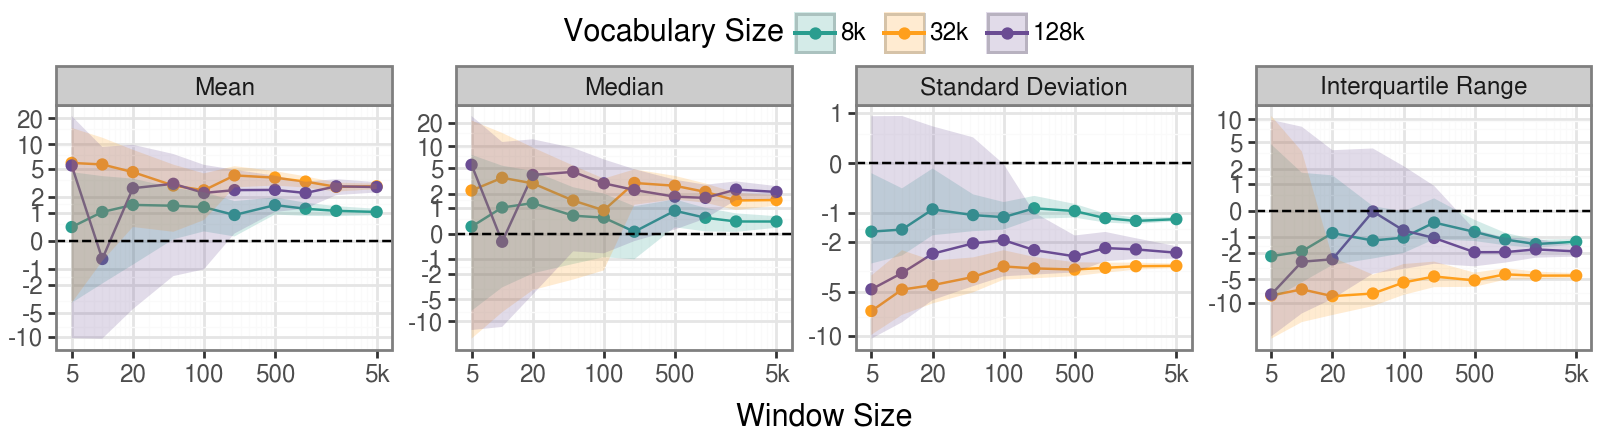

/home/pl487/merge-effect/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 2.2 in image.
/home/pl487/merge-effect/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/bpe_allwindow_sizes.pdf


In [49]:
cmap = {8064: "#2a9d8f", 32000: "#ff9f1c", 128000: "#6a4c93"}  # "#e76f51"}
map = {
    "mean": "Mean",
    "std": "Standard Deviation",
    "median": "Median",
    "iqr": "Interquartile Range",
    "8064": "8k",
    "32000": "32k",
    "128000": "128k",
}

pdata = win_df.filter(pl.col("model_size") == "81M-tied")

win_plot = (
    pn.ggplot(pdata, pn.aes("window_size", "ate", ymin="lower", ymax="upper"))
    + pn.geom_line(pn.aes(color="factor(vocab_size)"))
    + pn.geom_point(pn.aes(color="factor(vocab_size)"))
    + pn.geom_ribbon(pn.aes(fill="factor(vocab_size)"), alpha=0.2)
    + pn.geom_hline(yintercept=0, linetype="dashed")
    + pn.facet_wrap("target", ncol=4, scales="free", labeller=map)
    + pn.scale_colour_manual(cmap, labels=lambda x: [f"{v / 1000:.0f}k" for v in x])
    + pn.scale_fill_manual(cmap, labels=lambda x: [f"{v / 1000:.0f}k" for v in x])
    + pn.scale_y_symlog(breaks=[0, 1, 2, 5, 10, 20, -1, -2, -5, -10])
    + pn.scale_x_log10(
        breaks=[5, 20, 100, 500, 5000], labels=lambda x: [f"{v / 1000:.0f}k" if v >= 1000 else f"{v:.0f}" for v in x]
    )
    + pn.labs(x="Window Size", y="")
    + pn.theme_bw()
    + pn.theme(
        plot_margin=0.005,
        plot_background=None,
        legend_box_spacing=0.005,
        legend_box_margin=0,
        figure_size=(8, 2.2),
        legend_position="top",
        text=pn.element_text(family=font),
    )
    + pn.guides(fill=pn.guide_legend(title="Vocabulary Size"), colour=pn.guide_legend(title="Vocabulary Size"))
)
win_plot.show()
win_plot.save(plot_path / "bpe_allwindow_sizes.pdf")

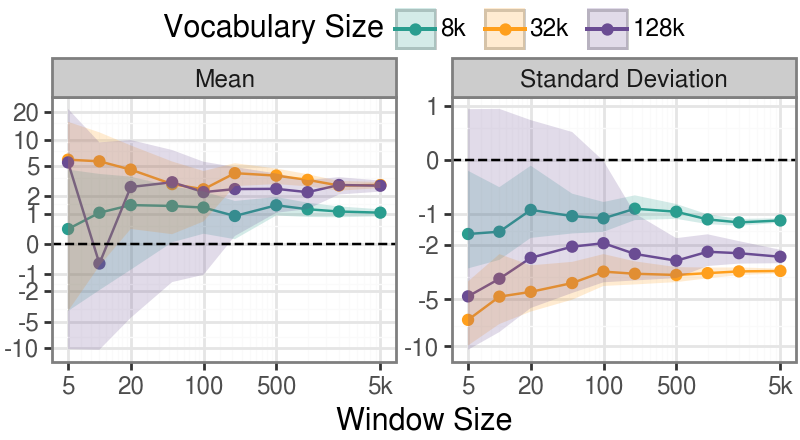

/home/pl487/merge-effect/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4 x 2.2 in image.
/home/pl487/merge-effect/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/bpe_allwindow_sizes_subset.pdf


In [50]:
cmap = {8064: "#2a9d8f", 32000: "#ff9f1c", 128000: "#6a4c93"}  # "#e76f51"}
map = {
    "mean": "Mean",
    "std": "Standard Deviation",
    "median": "Median",
    "iqr": "Interquartile Range",
    "8064": "8k",
    "32000": "32k",
    "128000": "128k",
}

pdata = win_df.filter((pl.col("model_size") == "81M-tied") & (pl.col("target").is_in(["mean", "std"])))

win_plot = (
    pn.ggplot(pdata, pn.aes("window_size", "ate", ymin="lower", ymax="upper"))
    + pn.geom_line(pn.aes(color="factor(vocab_size)"))
    + pn.geom_point(pn.aes(color="factor(vocab_size)"))
    + pn.geom_ribbon(pn.aes(fill="factor(vocab_size)"), alpha=0.2)
    + pn.geom_hline(yintercept=0, linetype="dashed")
    + pn.facet_wrap("target", ncol=4, scales="free", labeller=map)
    + pn.scale_colour_manual(cmap, labels=lambda x: [f"{v / 1000:.0f}k" for v in x])
    + pn.scale_fill_manual(cmap, labels=lambda x: [f"{v / 1000:.0f}k" for v in x])
    + pn.scale_y_symlog(breaks=[0, 1, 2, 5, 10, 20, -1, -2, -5, -10])
    + pn.scale_x_log10(
        breaks=[5, 20, 100, 500, 5000], labels=lambda x: [f"{v / 1000:.0f}k" if v >= 1000 else f"{v:.0f}" for v in x]
    )
    + pn.labs(x="Window Size", y="")
    + pn.theme_bw()
    + pn.theme(
        plot_margin=0.005,
        plot_background=None,
        legend_box_spacing=0.005,
        legend_box_margin=0,
        figure_size=(4, 2.2),
        legend_position="top",
        text=pn.element_text(family=font),
    )
    + pn.guides(fill=pn.guide_legend(title="Vocabulary Size"), colour=pn.guide_legend(title="Vocabulary Size"))
)
win_plot.show()
win_plot.save(plot_path / "bpe_allwindow_sizes_subset.pdf")

In [45]:
path = Path("data/me-minipile-evals")

eval_df = (
    pl.scan_parquet(list(path.glob("*parquet")), include_file_paths="filename")
    .with_columns(filename=pl.col("filename").str.split("/").list.get(-1).str.strip_suffix(".parquet"))
    .with_columns(
        tokenizer=pl.col("filename").str.extract("((bpe2wp)|(bpe)|(wordpiece))"),
        vocab_size=pl.col("filename").str.extract_all("(\d+)").list.get(-1).cast(pl.Int32),
        model_size=pl.col("filename").str.split("_").list.get(0).str.strip_prefix("me"),
    )
    .drop("filename")
    .select(["uid", "token_logprob", "tokenizer", "vocab_size", "step", "model_size"])
    .with_columns(pl.col("token_logprob").list.mean())
    .group_by(["tokenizer", "vocab_size", "step", "model_size"])
    .agg(pl.col("token_logprob").mean().neg())
    .collect()
    .shrink_to_fit()
)

In [48]:
ates = edf.filter((pl.col("step") > 0) & (pl.col("target") == "mean"))

In [49]:
map = {"bpe": "BPE", "wordpiece": "WordPiece", "bpe2wp": "BPE2WP"}
vmap = {8064: "8k", 32000: "32k", 128000: "128k"}

pdata = (
    eval_df.join(ates, on=["tokenizer", "vocab_size", "step", "model_size"])
    .sort("ate")
    .with_columns(
        label=pl.format(
            "{} {} {}",
            pl.col("tokenizer").replace_strict(map),
            pl.col("vocab_size").replace_strict(vmap),
            pl.col("model_size"),
        )
    )
    .filter(pl.col("model_size").is_in(["57M-tied"]))
)

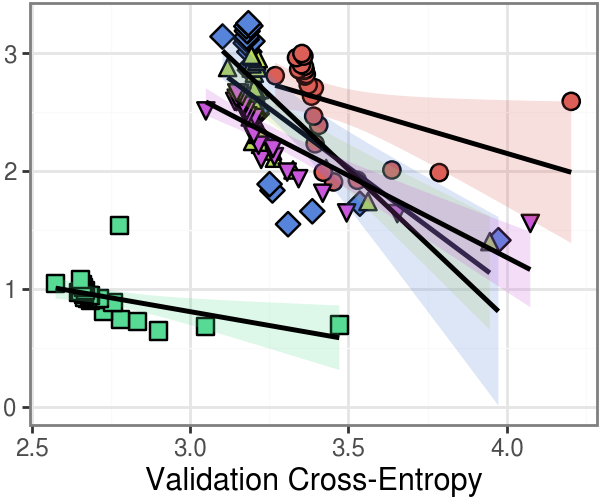

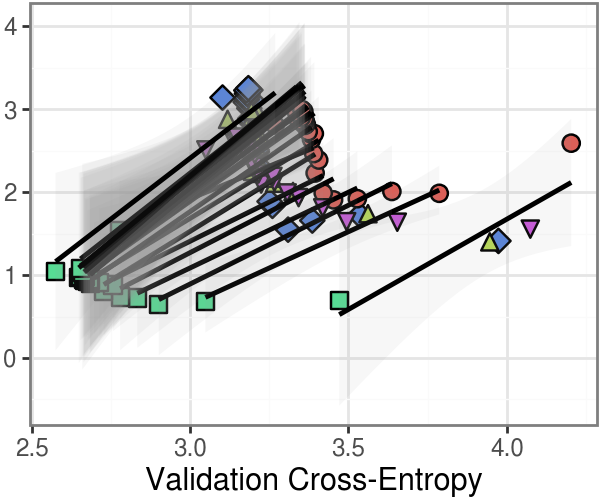

In [50]:
toks = (
    pn.ggplot(pdata, pn.aes("token_logprob", "ate", label="label", group="label", fill="label", shape="label"))
    + pn.geom_point(size=3)
    + pn.geom_smooth(method="lm", se=True, alpha=0.2)
    + pn.scale_fill_discrete(guide=None)
    + pn.theme_bw()
    + pn.scale_shape_discrete(guide=None)
    # + pn.scale_x_continuous(labels=lambda x: [""] * len(x))
    + pn.labs(x="Validation Cross-Entropy", y="")
    + pn.theme(
        plot_margin=0.005,
        plot_background=None,
        legend_box_spacing=0.005,
        legend_box_margin=0,
        figure_size=(3, 2.5),
        legend_position="top",
        text=pn.element_text(family=font),
        legend_justification="center",
        # legend_direction="horizontal",
        legend_box="horizontal",
        legend_justification_inside=True,
    )
    # + pn.guides(fill=pn.guide_legend(title="", nrow=2, byrow=True), shape=pn.guide_legend(title="", nrow=2, byrow=True))
)

steps = (
    pn.ggplot(pdata, pn.aes("token_logprob", "ate", label="label", group="step", fill="label", shape="label"))
    + pn.geom_point(size=3)
    + pn.geom_smooth(method="lm", se=True, alpha=0.08)
    + pn.scale_fill_discrete(guide=None)
    + pn.scale_shape_discrete(guide=None)
    + pn.labs(x="Validation Cross-Entropy", y="")
    + pn.theme_bw()
    + pn.theme(
        plot_margin=0.005,
        plot_background=None,
        legend_box_spacing=0.005,
        legend_box_margin=0,
        figure_size=(3, 2.5),
        text=pn.element_text(family=font),
        legend_box="vertical",
        legend_text_position="center",
    )
)
toks.show()
steps.show()

# toks.save(plot_path / "top.pdf")
# steps.save(plot_path / "bottom.pdf")

In [126]:
pdata = (
    ates.select(["vocab_size", "tokenizer", "model_size", "step", "ate"])
    .join(eval_df, on=["vocab_size", "tokenizer", "model_size", "step"], how="left")
    .filter(
        (pl.col("tokenizer") == "bpe")
        & (pl.col("vocab_size") == 32000)
        & (pl.col("step") > 0)
        & (~pl.col("model_size").is_in(["100M-tied", "100M"]))
    )
    # .with_columns(pl.col("model_size").cast(pl.Enum(["57M-tied", "100M-tied", "100M", "340M-tied", "850M"])))
    .with_columns(pl.col("model_size").cast(pl.Enum(["57M-tied", "340M-tied", "850M"])))
)

cmap = {"57M-tied": "#2a9d8f", "100M-tied": "#e76f51", "100M": "#f46197", "340M-tied": "#ff9f1c", "850M": "#6a4c93"}

/home/pl487/merge-effect/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 2.5 in image.
/home/pl487/merge-effect/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: new_plots/scaling_bpe_vocab32000.pdf


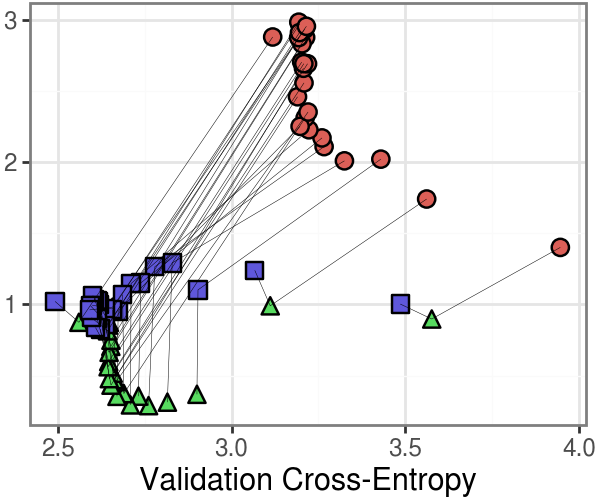

In [127]:
scaling_plot = (
    pn.ggplot(pdata, pn.aes("token_logprob", "ate", label="step", group="step", fill="model_size", shape="model_size"))
    + pn.geom_point(size=3)
    + pn.geom_line(size=0.1)
    # + pn.geom_smooth(method="lm", se=True, alpha=0.2)
    # + pn.scale_fill_discrete(guide=None)
    + pn.theme_bw()
    # + pn.scale_shape_discrete(guide=None)
    # + pn.scale_x_continuous(labels=lambda x: [""] * len(x))
    + pn.labs(x="Validation Cross-Entropy", y="")
    + pn.theme(
        plot_margin=0.005,
        plot_background=None,
        legend_box_spacing=0.005,
        legend_box_margin=0,
        figure_size=(3, 2.5),
        legend_position="none",
        text=pn.element_text(family=font),
        legend_justification="center",
        # legend_direction="horizontal",
        legend_box="horizontal",
        legend_justification_inside=True,
    )
    # + pn.guides(fill=pn.guide_legend(title="", nrow=2, byrow=True), shape=pn.guide_legend(title="", nrow=2, byrow=True))
)
scaling_plot.save(plot_path / "scaling_bpe_vocab32000.pdf")
scaling_plot.show()